In [1]:
# fixes a strange error that somethimes pops from the commands in the next 2 cells
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [1]:
! apt-get install -y git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [2]:
! rm -rf NLP-project
! git clone https://github.com/ReviBa/NLP-project
! cp -rf NLP-project/* .

Cloning into 'NLP-project'...
remote: Enumerating objects: 174, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 174 (delta 86), reused 115 (delta 34), pack-reused 0
Receiving objects: 100% (174/174), 9.67 MiB | 8.51 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [3]:
!pip install transformers
!pip install pytorch_pretrained_bert
!pip install sentencepiece
!pip install sentence_transformers
!pip install pytorch_lightning
!pip install datasets
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.4
    Uninstalling urllib3-2.0.4:
      Successfully uninstalled urllib3-2.0.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# this file can't be used here because other modules versions are needed. specifically load_state_dict doesn't work we older versions of libraries.
#!pip install -r requirements.txt

In [5]:
import pandas as pd

# DL
import torch
from torch.optim import Adam


# from datasets import load_dataset
from transformers import BertTokenizer
from transformers import T5Tokenizer
from transformers import BertForSequenceClassification

# display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

In [6]:
from t5.train import t5_train
from utils.tokens_utils import get_tokenizer_based_on_data, get_max_tokens_number
from t5.model import T5Model
from classifier.utils import freeze_bert_top_layers
from classifier.data_preperation import prepare_data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
assert DEVICE == 'cuda'

### Loading classifier from pretrained

In [9]:
classifier_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2, # Michael and other
    output_attentions = False,
    output_hidden_states = False)

classifier_model.to(DEVICE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [10]:
top_layer_params = freeze_bert_top_layers(classifier_model)

In [11]:
optimizer = Adam(top_layer_params, lr=0.0001)

load weights of a trained classifier

In [12]:
checkpoint = torch.load('/content/drive/MyDrive/classifier_on_michael_bert.pt')
classifier_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

### Load Models - daily dialog + transcript dialog T5 + style transfer with T5

In [13]:
TRAIN_BATCH_SIZE = 4 # batch size of training
VAL_BATCH_SIZE = 4 # batch size for validation
EPOCHS = 1 # number of epoch
MODEL_NAME = "t5-base"

#### Daily Dialog

In [14]:
daily_dialog_tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME, model_max_length=512)
daily_dialog_model = T5Model(MODEL_NAME)
checkpoint_daily_dialog = torch.load('/content/drive/MyDrive/NLP project/Option3-trained-on-daily-dialog-splitted-corpus-second-epoch.ckpt')
daily_dialog_model.load_state_dict(checkpoint_daily_dialog['state_dict'])
daily_dialog_model.freeze()
daily_dialog_model.to(DEVICE)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=True`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


T5Model(
  (model): T5ForConditionalGeneration(
    (shared): Embedding(32128, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): Linear(in_features=30

#### Transcript

In [15]:
tokenizer_transcript = T5Tokenizer.from_pretrained('/content/drive/MyDrive/NLP project/the-office-tokenizer')
transcript_model = T5Model(MODEL_NAME)
transcript_model.model.resize_token_embeddings(len(tokenizer_transcript))
checkpoint_test = torch.load('/content/drive/MyDrive/sentence-completion-above-daily-dialog.ckpt')
transcript_model.load_state_dict(checkpoint_test['state_dict'])
transcript_model.freeze()
transcript_model.to(DEVICE)

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 40763. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


T5Model(
  (model): T5ForConditionalGeneration(
    (shared): Embedding(40763, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(40763, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): Linear(in_features=30

#### Style Transfer

In [16]:
# Using regular T5 was causing problems. he was trained on different languages,
# so sometimes it returned results that are not in english.
STYLE_TRANS_MODEL_NAME = "google/t5-v1_1-base"
BATCH_SIZE = 4
PATH = "/content/NLP-project/resources/embeddings_comparison_mini_cosine.csv"

In [17]:
style_transfer_df = pd.read_csv(PATH)
style_transfer_df = style_transfer_df[style_transfer_df['cosine']<=0.45]
cols = ['input', 'target']
train_df =  style_transfer_df.rename(columns={'sentence': cols[0], 'all-MiniLM-L6-v2 with cosine': cols[1]})[cols].drop_duplicates()

In [18]:
style_trans_max_input_len, _ = get_max_tokens_number(train_df, *cols)

In [19]:
tokenizer_style_trans = get_tokenizer_based_on_data(train_df, *cols)
style_trans_model = T5Model(STYLE_TRANS_MODEL_NAME)
style_trans_model.model.resize_token_embeddings(len(tokenizer_style_trans))
checkpoint_test = torch.load('/content/drive/MyDrive/style_transfer_model-9-epochs-on-new-data-and-more.ckpt')
style_trans_model.load_state_dict(checkpoint_test['state_dict'])
style_trans_model.freeze()
style_trans_model.to(DEVICE)

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 36914. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


T5Model(
  (model): T5ForConditionalGeneration(
    (shared): Embedding(36914, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(36914, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseGatedActDense(
                (wi_0): Linear(in_features=768, out_features=2048, bias=False)
                (wi_1): Linear(in_fe

###**Generate responses from all models**

In [20]:
from datasets import load_dataset
dataset = load_dataset("daily_dialog")

Generating train split:   0%|          | 0/11118 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [21]:
simple_sentences = []

for row in dataset['train']['dialog']:
  i = 2
  while i <= len(row):
    dialog = row[:i]
    context = dialog[:-1]
    simple_sentences.append(context[0])
    i += 2

simple_sentences = set(simple_sentences)

In [22]:
len(simple_sentences)

9346

In [23]:
max_input_len = max([len(sent.split()) for sent in simple_sentences])

Utils for response generation

In [24]:
import re
from tqdm import tqdm

def clean_response(response):
  response = re.sub('<[^>]+>', '', response)
  response = response.strip()
  return response

def generate_model_response(model, tokenizer, input, max_len):
  inputs_encoding = tokenizer(
      input,
      add_special_tokens=True,
      max_length=max_len,
      padding = 'max_length',
      truncation = True,
      return_attention_mask=True,
      return_tensors="pt"
      )

  generate_ids = model.model.generate(
    input_ids = inputs_encoding["input_ids"].to(DEVICE),
    attention_mask = inputs_encoding["attention_mask"].to(DEVICE),
    max_length = max_len,
    num_return_sequences = 1,
    no_repeat_ngram_size=2,
    early_stopping=True,
    )

  preds = [
    tokenizer.decode(gen_id,
    skip_special_tokens=False,
    clean_up_tokenization_spaces=True)
    for gen_id in generate_ids
  ]
  return list(map(clean_response, preds))

def generate_model_response_in_batches(model, tokenizer, input, batch_size, max_len):
  full_res = []
  for i in tqdm(range(0, len(input), batch_size)):
    res = generate_model_response(model, tokenizer, input[i:i + batch_size], max_len)
    full_res += res

  return full_res

In [25]:
import random

# take only sample for evaluation
sampled = random.sample(simple_sentences, 1500)

transcript_inputs = []
daily_dialog_inputs = []

# adapting each input to the models' input
for sent in sampled:
  transcript_input = "Person1:Michael, " + sent # need to refer to Michael
  transcript_inputs.append(transcript_input)
  daily_dialog_input = "Person1:" + sent
  daily_dialog_inputs.append(daily_dialog_input)


daily_dialog_results = generate_model_response_in_batches(daily_dialog_model, daily_dialog_tokenizer, daily_dialog_inputs, 10, max_input_len)
transcript_results = generate_model_response_in_batches(transcript_model, tokenizer_transcript, transcript_inputs, 10, max_input_len)

daily_dialog_results_clean = [clean_response(res).replace("Person2:", "") for res in daily_dialog_results]
transcript_results_clean = [clean_response(res).replace("Michael:", "") for res in transcript_results]

# the style transfer model gets its input from the output of the daily-dialog model
style_transfer_results = generate_model_response_in_batches(style_trans_model, tokenizer_style_trans, daily_dialog_results_clean, 10, style_trans_max_input_len)

<ipython-input-25-6790b9dc51e5>:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled = random.sample(simple_sentences, 1500)
  0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
100%|██████████| 150/150 [01:48<00:00,  1.38it/s]


In [26]:
def add_speaker_column(lines, speaker_default):
  rows = [(line, speaker_default) for line in lines]
  return pd.DataFrame(rows, columns=['line', 'speaker'])

In [27]:
daily_dialog_results_df = add_speaker_column(daily_dialog_results_clean, 'other')
transcript_results_df = add_speaker_column(transcript_results_clean, 'other')
style_transfer_results_df = add_speaker_column(style_transfer_results, 'other')

### **Prepare data to run through the classifier**

In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [29]:
PAD_TOKEN = 0
EPOCHS = 10

{'Michael': 0, 'other': 1} - the labels on which the classifier was trained

In [30]:
label2id = {'Michael': 0, 'other': 1}

In [31]:
# df_train is of type ['line', 'speaker']
compared_seq_daily_dialog = prepare_data(daily_dialog_results_df, label2id, tokenizer, batch_size=256)
compared_seq_transcript = prepare_data(transcript_results_df, label2id, tokenizer, batch_size=256)
compared_seq_style_transfer = prepare_data(style_transfer_results_df, label2id, tokenizer, batch_size=256)

### **Perform evaluation of improvement**

In [37]:
def check_improvement(data_loader1, data_loader2, model, dl1_name="data_loader1", dl2_name="data_loader2"):

  count_dl2_better_than_dl1 = 0
  count_dl1_better_than_dl2 = 0

  not_michael_dl1 = 0
  not_michael_dl2 = 0

  for (inputs1, pad_mask1, _), (inputs2, pad_mask2, _) in zip(data_loader1, data_loader2):

    inputs1 = inputs1.to(DEVICE)
    pad_mask1 = pad_mask1.to(DEVICE)

    inputs2 = inputs2.to(DEVICE)
    pad_mask2 = pad_mask2.to(DEVICE)

    with torch.no_grad():
        outputs1 = model(inputs1, pad_mask1).logits
        _, preds1 = torch.max(outputs1, 1)

        outputs2 = model(inputs2, pad_mask2).logits
        _, preds2 = torch.max(outputs2, 1)

        for pred1, pred2 in zip(preds1, preds2):
          if pred1 == label2id['other'] and pred2 == label2id['Michael']: # there was an improvement from dl1 to dl2
            count_dl2_better_than_dl1 += 1
          elif pred1 == label2id['Michael'] and pred2 == label2id['other']: # there was an improvement from dl2 to dl1
            count_dl1_better_than_dl2 += 1

          if pred1 == label2id['other']:
            not_michael_dl1 += 1
          if pred2 == label2id['other']:
            not_michael_dl2 += 1

  # improvement percentage
  improvements_from_dl1_to_dl2 = (count_dl2_better_than_dl1 / not_michael_dl1) * 100 if not_michael_dl1 > 0 else 0
  improvements_from_dl2_to_dl1 = (count_dl1_better_than_dl2 / not_michael_dl2) * 100 if not_michael_dl2 > 0 else 0


  y = np.array([len(data_loader1.dataset) - not_michael_dl1, not_michael_dl1])
  mylabels = ["Michael", "other"]

  absolute_value = lambda x: np.round(x/100.*y.sum(), 0)

  plt.title(dl1_name)
  plt.pie(y, labels = mylabels, startangle = 90, autopct='%.1f%%')
  fig = plt.gcf()
  fig.set_size_inches(2,2) # or (4,4) or (5,5) or whatever
  plt.show()

  y = np.array([len(data_loader2.dataset) - not_michael_dl2, not_michael_dl2])
  mylabels = ["Michael", "other"]

  absolute_value = lambda x: np.round(x/100.*y.sum(), 0)

  plt.title(dl2_name)
  plt.pie(y, labels = mylabels, startangle = 90, autopct='%.1f%%')
  fig = plt.gcf()
  fig.set_size_inches(2,2) # or (4,4) or (5,5) or whatever
  plt.show()


  return improvements_from_dl1_to_dl2, improvements_from_dl2_to_dl1

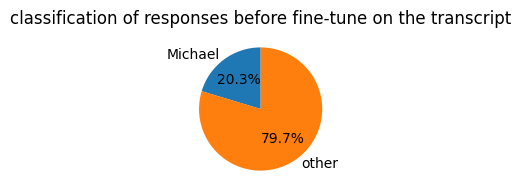

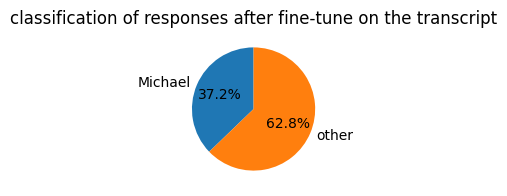

(36.56903765690377, 19.53290870488323)

In [38]:
check_improvement(compared_seq_daily_dialog, compared_seq_transcript, classifier_model, "classification of responses before fine-tune on the transcript", "classification of responses after fine-tune on the transcript")

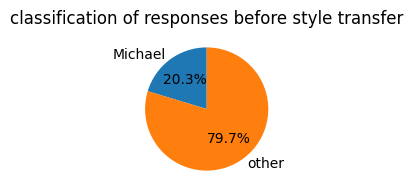

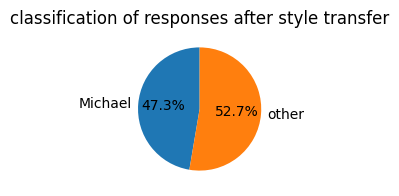

(48.03347280334728, 21.39240506329114)

In [39]:
check_improvement(compared_seq_daily_dialog, compared_seq_style_transfer, classifier_model, "classification of responses before style transfer", "classification of responses after style transfer")

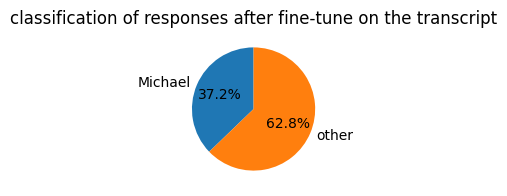

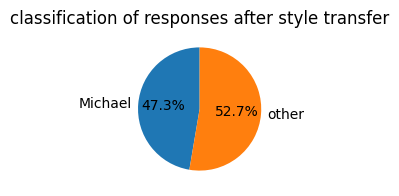

(46.70912951167728, 36.45569620253165)

In [40]:
check_improvement(compared_seq_transcript, compared_seq_style_transfer, classifier_model, "classification of responses after fine-tune on the transcript", "classification of responses after style transfer")